## Подключение вспомогательных библиотек

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import importlib.util

## Подключение библиотеки `gmdhpy`

In [2]:
sys.path.insert(1, "C:/Users/Mi/Documents/Diploma/GMDH/build/Release")
sys.path.insert(1, "/home/mikhail-xnor/Projects/GMDH/build")
import gmdhpy as gm

In [3]:
print("Состав библиотеки")
dir(gm)

Состав библиотеки


['Combi',
 'Criterion',
 'CriterionType',
 'GmdhModel',
 'Mia',
 'Multi',
 'ParallelCriterion',
 'PolynomialType',
 'Ria',
 'SequentialCriterion',
 'Solver',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'split_data',
 'splitted_data',
 'time_series_transformation']

## Код для линейной регрессии, реализация combi на python, функции метрик

In [4]:
def data_preparation(x, lags, validate_size, test_size=0):
    x_data = list()
    y_data = list()
    for i in range(len(x) - lags):
        x_data.append(list(x[i:i+lags]))
        y_data.append(x[i+lags])
    x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=validate_size, shuffle=False)
    x_train = np.array(x_train)
    x_val = np.array(x_val)
    if test_size > 0:
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=test_size, shuffle=False)
        x_train = np.array(x_train)
        x_test = np.array(x_test)
        return x_train, y_train, x_test, y_test, x_val, y_val
    else:
        return x_train, y_train, x_val, y_val

def print_polynom(polynom, coeffs):
    best_polynom_str = "y ="
    for i in range(len(polynom)):
        if coeffs[i] > 0:
            if i > 0:
                best_polynom_str += " + "
            else:
                best_polynom_str += " "
        else:
            best_polynom_str += " - "
        best_polynom_str += str(round(abs(coeffs[i]), 4))
        if i != len(coeffs) - 1:
            best_polynom_str += "*x" + str(polynom[i] + 1)
    print(best_polynom_str)
    
def regression(x, lags, validate_size):
    x_train, y_train, x_val, y_val = data_preparation(x, lags, validate_size)
    lr = LinearRegression(n_jobs=-1)
    lr.fit(x_train, y_train)
    coeffs = list(lr.coef_)
    coeffs.append(lr.intercept_)
    coeffs = [round(coeff, 6) for coeff in coeffs]
    y_pred = lr.predict(x_val)
    error = round(mean_squared_error(y_pred, y_val), 6)
    print_polynom(range(lags + 1), coeffs)
    return y_pred

def regression_combi(x, lags, validate_size, test_size):
    x_train, y_train, x_test, y_test, x_val, y_val = data_preparation(x, lags, validate_size, test_size)
    lr = LinearRegression(n_jobs=-1)
    last_error = 100000000000000
    best_coeffs = []
    best_polynom = []
    for level in range(1, x_train.shape[1] + 1):
        errors = []
        for comb in combinations(range(x_train.shape[1]), level):
            lr.fit(x_train[:, comb], y_train)
            coeffs = list(lr.coef_)
            coeffs.append(lr.intercept_)
            coeffs = [round(coeff, 6) for coeff in coeffs]
            y_pred = lr.predict(x_test[:, comb])
            error = round(mean_squared_error(y_pred, y_test), 6)
            comb = list(comb)
            comb.append(lags)
            errors.append((error, coeffs, comb))
        errors.sort()
        #print(errors[0])
        if last_error >= errors[0][0]:
            last_error = errors[0][0]
            best_coeffs = errors[0][1]
            best_polynom = errors[0][2]
        else:
            break
    print_polynom(best_polynom, best_coeffs)
    y_pred = lr.fit(x_train[:, best_polynom[:-1]], y_train).predict(x_val[:, best_polynom[:-1]])
    return y_pred

def print_metrics(y_test, y_pred):
    print("\nMETRICS")
    print(f"R^2: {r2_score(y_test, y_pred)}")
    print(f"MSE: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}\n")
    
def ts_stat(y_real, y_pred):
    y_real_diff = np.diff(y_real)
    y_pred_diff = np.diff(y_pred)
    print("right:", ((y_real_diff * y_pred_diff > 0)).sum())
    print("wrong:", ((y_real_diff * y_pred_diff < 0)).sum())
    print("zero:", ((y_real_diff * y_pred_diff == 0)).sum())

## Загрузка и предобработка датасета

In [5]:
datasets = ['numbers', 'sber', 'notebooks']
chosen_dataset = datasets[1]

In [6]:
if chosen_dataset == datasets[0]:
    data = np.array(range(50))
    lags = 5
    test_size = 0.33
    validate_size = 0.2

    mat, vec = gm.time_series_transformation(data, lags)
    splited_data = gm.split_data(mat, vec, validate_size, False, 0)
    
elif chosen_dataset == datasets[1]:
    data = pd.read_csv("Sberbank.csv")['close'][:-50000]
    lags = 10
    test_size = 0.33
    validate_size = 0.2

    mat, vec = gm.time_series_transformation(data, lags)
    splited_data = gm.split_data(mat, vec, validate_size, False, 0)

elif chosen_dataset == datasets[2]:
    data = pd.read_csv("laptop_price.csv")
    #data = data[data.columns[data.dtypes != object]].drop(['laptop_ID', 'Memory2_GB'], axis=1)
    data = data.drop(['laptop_ID', 'Memory2_GB'], axis=1)
    data = data.drop(data[data['Ram_GB'] == 64].index)
    test_size = 0.2
    validate_size = 0.2
    category_cols = data.columns[data.dtypes == object]
    #for col in category_cols:
    #    print(f'{col}: {data[col].unique().size}')
    data = pd.get_dummies(data=data.drop(['Product', 'Cpu_series', 'Gpu_series'], axis=1), 
                          columns=category_cols.drop(['Product', 'Cpu_series', 'Gpu_series']))
    splited_data = gm.split_data(data.drop(['Price_euros'], axis=1), data['Price_euros'])
    scaler = MinMaxScaler().fit(splited_data.x_train)
    splited_data.x_train = scaler.transform(splited_data.x_train)
    splited_data.x_test = scaler.transform(splited_data.x_test)

else: print("unknown option:", chosen_dataset)

## Обучение моделей

In [7]:
%%time
print("COMBI model\n")
combi = gm.Combi()
combi.fit(splited_data.x_train, splited_data.y_train, 
          criterion=gm.SequentialCriterion(gm.CriterionType.regularity, gm.CriterionType.stability, solver=gm.Solver.accurate), 
          test_size=test_size, shuffle=False, random_state=17, p_average=1, n_jobs=-1, verbose=1, limit=0)
print("\n" + combi.get_best_polynomial())
y_pred_combi = combi.predict(splited_data.x_test)
print_metrics(splited_data.y_test, y_pred_combi)

COMBI model

LEVEL 1  [=========================] 100% :00s] (10 combinations) error=5261.230194                                 
LEVEL 2  [=========================] 100% :00s] (45 combinations) error=5260.698317                                 
LEVEL 3  [=========================] 100% :00s] (120 combinations) error=5259.523471                                
LEVEL 4  [=========================] 100% :01s] (210 combinations) error=5259.079665                                
LEVEL 5  [=========================] 100% :01s] (252 combinations) error=5258.942811                                
LEVEL 6  [=========================] 100% :01s] (210 combinations) error=5258.962065                                

y = 0.0075*x1 - 0.0056*x2 - 0.0085*x4 + 0.014*x9 + 0.9925*x10 + 0.013

METRICS
R^2: 0.9994748816054192
MSE: 0.3265933930907824
MAE: 0.3614355896535036

CPU times: total: 34 s
Wall time: 6.39 s


In [8]:
%%time
print("MULTI model\n")
multi = gm.Multi()
multi.fit(splited_data.x_train, splited_data.y_train, 
          criterion=gm.Criterion(gm.CriterionType.regularity, gm.Solver.accurate), 
          k_best=3, test_size=test_size, shuffle=True, random_state=17, p_average=1, n_jobs=-1, verbose=1, limit=0);
print("\n" + multi.get_best_polynomial())
y_pred_multi = multi.predict(splited_data.x_test)
print_metrics(splited_data.y_test, y_pred_multi)

MULTI model

LEVEL 1  [=========================] 100% :00s] (10 combinations) error=1721.456974                                 
LEVEL 2  [=========================] 100% :00s] (24 combinations) error=1721.130918                                 
LEVEL 3  [=========================] 100% :00s] (21 combinations) error=1720.883707                                 
LEVEL 4  [=========================] 100% :00s] (20 combinations) error=1720.883364                                 
LEVEL 5  [=========================] 100% :00s] (15 combinations) error=1720.87261                                  
LEVEL 6  [=========================] 100% :00s] (13 combinations) error=1720.870739                                 
LEVEL 7  [=========================] 100% :00s] (10 combinations) error=1720.795442                                 
LEVEL 8  [=========================] 100% :00s] (7 combinations) error=1720.793897                                  
LEVEL 9  [=========================] 100% :00s] (4 

In [9]:
%%time
print("MIA model\n")
mia = gm.Mia()
mia.fit(splited_data.x_train, splited_data.y_train, 
        criterion=gm.Criterion(gm.CriterionType.sym_regularity, gm.Solver.accurate), 
        k_best=5, polynomial_type=gm.PolynomialType.quadratic, test_size=test_size, shuffle=1, 
        random_state=17, p_average=1, n_jobs=-1, verbose=1, limit=0);
print("\n" + mia.get_best_polynomial())
y_pred_mia = mia.predict(splited_data.x_test)
print_metrics(splited_data.y_test, y_pred_mia)

MIA model

LEVEL 1  [=========================] 100% :00s] (45 combinations) error=5254.102698                                 
LEVEL 2  [=========================] 100% :00s] (10 combinations) error=5252.267502                                 
LEVEL 3  [=========================] 100% :00s] (10 combinations) error=5252.29803                                  

f1_1 = 0.0014*x1 + 0.9986*x10 - 0.0044*x1*x10 + 0.0022*x1^2 + 0.0022*x10^2 + 0.0025
f1_2 = - 0.0013*x5 + 1.0012*x10 - 0.0052*x5*x10 + 0.0026*x5^2 + 0.0026*x10^2 + 0.004

y = 3.1818*f1_1 - 2.1818*f1_2 - 27.2088*f1_1*f1_2 + 13.5947*f1_1^2 + 13.6141*f1_2^2 - 0.0011

METRICS
R^2: 0.9994740794808329
MSE: 0.3270922683787568
MAE: 0.36116806524318784

CPU times: total: 3.31 s
Wall time: 695 ms


In [10]:
%%time
print("RIA model\n")
ria = gm.Ria()
ria.fit(splited_data.x_train, splited_data.y_train, 
        criterion=gm.Criterion(gm.CriterionType.regularity, gm.Solver.accurate),
        k_best=3, polynomial_type=gm.PolynomialType.linear, test_size=test_size, shuffle=False, 
        random_state=0, p_average=1, n_jobs=-1, verbose=1, limit=1e-4)
print("\n" + ria.get_best_polynomial())
y_pred_ria = ria.predict(splited_data.x_test)
print_metrics(splited_data.y_test, y_pred_ria)

RIA model

LEVEL 1  [=========================] 100% :00s] (45 combinations) error=2768.366549                                 
LEVEL 2  [=========================] 100% :00s] (30 combinations) error=2767.836092                                 
LEVEL 3  [=========================] 100% :00s] (30 combinations) error=2767.690027                                 
LEVEL 4  [=========================] 100% :00s] (30 combinations) error=2767.639372                                 
LEVEL 5  [=========================] 100% :00s] (30 combinations) error=2767.623351                                 
LEVEL 6  [=========================] 100% :00s] (30 combinations) error=2767.616672                                 
LEVEL 7  [=========================] 100% :00s] (30 combinations) error=2767.61489                                  
LEVEL 8  [=========================] 100% :00s] (30 combinations) error=2767.614155                                 
LEVEL 9  [=========================] 100% :00s] (30 c

In [11]:
%%time
print("COMBI on python model\n")
y_pred_lr_combi = regression_combi(data, lags, validate_size, test_size)
print_metrics(splited_data.y_test, y_pred_lr_combi)

COMBI on python model

y = 0.0074*x1 - 0.0055*x2 - 0.0086*x4 + 0.0141*x9 + 0.9925*x10 + 0.0131

METRICS
R^2: 0.9994748809277221
MSE: 0.32659381457936076
MAE: 0.36143711131149997

CPU times: total: 1min 6s
Wall time: 1min 6s


In [12]:
%%time
print("LR python model\n")
y_pred_lr = regression(data, lags, validate_size)
print_metrics(splited_data.y_test, y_pred_lr)

LR python model

y = 0.0093*x1 - 0.0072*x2 + 0.0021*x3 - 0.0099*x4 + 0.0087*x5 - 0.0164*x6 + 0.0023*x7 + 0.0025*x8 + 0.019*x9 + 0.9897*x10 - 0.003

METRICS
R^2: 0.9994755363273505
MSE: 0.32618619376338387
MAE: 0.36083890315030326

CPU times: total: 15 s
Wall time: 15.1 s


## Сравнение результатов

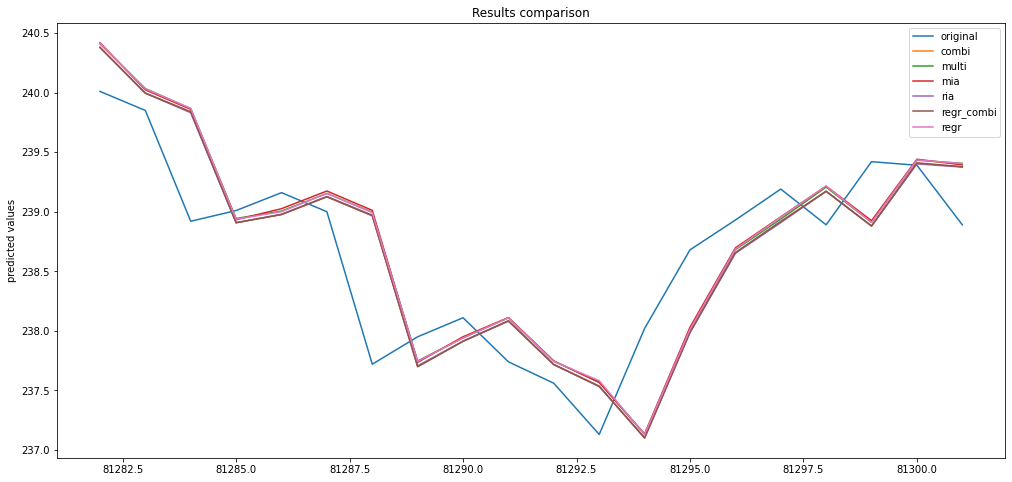

In [13]:
show_train = False
test_n = 20 #splited_data.y_test.shape[0]

start_test = splited_data.y_train.shape[0]
end_test = start_test + test_n
plt.figure(figsize=(17, 8))
if show_train:
    sns.lineplot(x=np.arange(0, end_test), y=list(splited_data.y_train) + list(splited_data.y_test[:test_n]), label='original');
else:
    sns.lineplot(x=np.arange(start_test, end_test), y=splited_data.y_test[:test_n], label='original');
sns.lineplot(x=np.arange(start_test, end_test), y=y_pred_combi[:test_n], label='combi');
sns.lineplot(x=np.arange(start_test, end_test), y=y_pred_multi[:test_n], label='multi');
sns.lineplot(x=np.arange(start_test, end_test), y=y_pred_mia[:test_n], label='mia');
sns.lineplot(x=np.arange(start_test, end_test), y=y_pred_ria[:test_n], label='ria');
sns.lineplot(x=np.arange(start_test, end_test), y=y_pred_lr_combi[:test_n], label='regr_combi');
sns.lineplot(x=np.arange(start_test, end_test), y=y_pred_lr[:test_n], label='regr');
plt.title("Results comparison")
plt.ylabel("predicted values")
plt.show();

In [14]:
print("Оценка верных предсказаний направления изменения цен акции\n")
print("COMBI")
ts_stat(splited_data.y_test, y_pred_combi)
print("\nMULTI")
ts_stat(splited_data.y_test, y_pred_multi)
print("\nMIA")
ts_stat(splited_data.y_test, y_pred_mia)
print("\nRIA")
ts_stat(splited_data.y_test, y_pred_ria)
print("\nCOMBI on python")
ts_stat(splited_data.y_test, y_pred_lr_combi)
print("\nLR")
ts_stat(splited_data.y_test, y_pred_lr)

Оценка верных предсказаний направления изменения цен акции

COMBI
right: 9414
wrong: 10602
zero: 304

MULTI
right: 9420
wrong: 10596
zero: 304

MIA
right: 9410
wrong: 10606
zero: 304

RIA
right: 9415
wrong: 10601
zero: 304

COMBI on python
right: 9417
wrong: 10599
zero: 304

LR
right: 9412
wrong: 10604
zero: 304


## Пример обработки некорректных данных

In [15]:
try:
    y_pred_multi = multi.predict(np.delete(splited_data.x_test, -1, 1))
except Exception as err:
    print(err)

Input data number of cols is not match number of cols of fitted data!


## Пример сохранения и загрузки модели из файла

In [16]:
mia.save("mia1.txt")
new_mia = gm.Mia()
new_mia.load("mia1.txt")
print("\n" + mia.get_best_polynomial())
y_pred_new_mia = new_mia.predict(splited_data.x_test)
print_metrics(splited_data.y_test, y_pred_mia)


f1_1 = 0.0014*x1 + 0.9986*x10 - 0.0044*x1*x10 + 0.0022*x1^2 + 0.0022*x10^2 + 0.0025
f1_2 = - 0.0013*x5 + 1.0012*x10 - 0.0052*x5*x10 + 0.0026*x5^2 + 0.0026*x10^2 + 0.004

y = 3.1818*f1_1 - 2.1818*f1_2 - 27.2088*f1_1*f1_2 + 13.5947*f1_1^2 + 13.6141*f1_2^2 - 0.0011

METRICS
R^2: 0.9994740794808329
MSE: 0.3270922683787568
MAE: 0.36116806524318784

